In [3]:
import ee
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as PILImage
import requests
from io import BytesIO
from IPython.display import Image
ee.Authenticate()

ee.Initialize(project='ee-philipkenneweg')




# Define the urban location of interest as a point near Lyon, France.
u_lon = 8.5325
u_lat = 52.03202
u_poi = ee.Geometry.Point(u_lon, u_lat)
roi = u_poi.buffer(3e3)

def get_img_from_url(url):
    response = requests.get(url)
    img = PILImage.open(BytesIO(response.content))

    # Convert the image to a NumPy array
    img_array = np.array(img)

    # print(img_array.shape)
    # print(img_array.dtype)
    # print(img_array.min(), img_array.max())

    # plt.imshow(img_array)
    # plt.show()
    return img_array

def get_temp_img(i_date, f_date):

    # Import the MODIS land surface temperature collection.
    lst = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')#ee.ImageCollection('MODIS/006/MOD11A1')
    # Selection of appropriate bands and dates for LST.
    lst = lst.select('temperature_2m').filterDate(i_date, f_date)
   # print(lst.size().getInfo())
    if lst.size().getInfo() == 0:
        print('No temp data available for the given time period.')
        return
    # Reduce the LST collection by mean.
    lst_img = lst.mean()
    # Convert Kelvin to Celsius.
    lst_img = lst_img.select('temperature_2m').add(-273.15)

    url = lst_img.getThumbUrl({
        'min': -20, 'max':  30,'dimensions': 512, 'region': roi})#,'palette': ['blue', 'yellow', 'orange', 'red']})

    array = get_img_from_url(url)
    
    array = array*(50/255)-20.0
    print(array.min(), array.max())
    np.save('data/'+i_date+'temp.npy', array)

    return array

def get_tmp_graph(i_date, f_date):

    # Import the MODIS land surface temperature collection.
    lst = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR')#ee.ImageCollection('MODIS/006/MOD11A1')
    # Selection of appropriate bands and dates for LST.
    lst = lst.select('temperature_2m').filterDate(i_date, f_date)
   # print(lst.size().getInfo())
    if lst.size().getInfo() == 0:
        print('No temp data available for the given time period.')
        return
    # Reduce the LST collection by mean.
    #for 
    lst_u_poi = lst.getRegion(u_poi, 1000).getInfo()
    tmp_list = []
    for i in range(1,len(lst_u_poi)):
      # print(lst_u_poi[i][4])
        tmp_list.append(lst_u_poi[i][4])
   # print(lst_u_poi)
    lst_u_poi  = np.asarray(tmp_list)-273.15
   # for i in range(1,128):
    return lst_u_poi
   # print(lst_u_poi)
   # print(lst_u_poi[:5])
   # print(lst.mean().sample(u_poi).first().get('temperature_2m').getInfo())
   


def get_satellite_img(i_date, f_date):
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(roi)
    .filterDate(i_date, f_date)
    .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 20)))

    print(s2_sr_col.size().getInfo())
    if s2_sr_col.size().getInfo() == 0:
        print('No img data available for the given time period.')
        return
    sl2_img = s2_sr_col.mean()
    url = sl2_img.getThumbURL({'dimensions': 512, 'region': roi,'bands': ['B4', 'B3', 'B2'], "min": 0, "max": 3000})

    array = get_img_from_url(url)
    #print(array.shape)
    np.save('data/'+i_date+'rgb.npy', array)
    return array

def get_landcover_img(i_date, f_date):
    col = ee.ImageCollection("COPERNICUS/CORINE/V20/100m").filterBounds(roi).filterDate(i_date, f_date)

    if s2_sr_col.size().getInfo() == 0:
        print('No img data available for the given time period.')
        return

    img = col.mean()
    url = img.getThumbURL({'dimensions': 512, 'region': roi,'bands': ['landcover']})
    array = get_img_from_url(url)

    np.save('data/'+i_date+'landcover.npy', array)
    return array

import datetime
from dateutil.relativedelta import relativedelta
satellite_imgs_monthly = []
temps_monthly = []
startdate = datetime.datetime(2019, 1, 1)

dates = []
#startdate = startdate.strftime("%Y-%m-%d")
for i in range(70):
    #print("Current month", i+1)
    dates.append(startdate)
    i_date = startdate.strftime("%Y-%m-%d")#"2024-"+str(i+1).zfill(2)+"-01"
    f_date = (startdate + relativedelta(months = 1)).strftime("%Y-%m-%d")#"2024-"+str(i+1).zfill(2)+"-28"
    startdate = startdate + relativedelta(months = 1)
    print(i_date, f_date)
    list_tmps = get_tmp_graph(i_date, f_date)
    img = get_satellite_img(i_date, f_date)
    if img is None:
        img = np.zeros((318, 512, 3))
    satellite_imgs_monthly.append(img)
    temps_monthly.append(list_tmps)
   # plt.imshow(img)
    # temp = get_temp_img(i_date, f_date)
    # if temp is None:
    #     continue
    # cover = get_landcover_img(i_date, f_date)
    # if cover is None:
    #     continue

   # print(cover)

import pickle
with open('data/satellite_imgs_monthly.pkl', 'wb') as f:
    pickle.dump(satellite_imgs_monthly, f)
with open('data/temps_monthly.pkl', 'wb') as f:
    pickle.dump(temps_monthly, f)
with open('data/dates.pkl', 'wb') as f:
    pickle.dump(dates, f)
    






2019-01-01 2019-02-01
2
2019-02-01 2019-03-01
2
2019-03-01 2019-04-01
2
2019-04-01 2019-05-01
6
2019-05-01 2019-06-01
3
2019-06-01 2019-07-01
4
2019-07-01 2019-08-01
2
2019-08-01 2019-09-01
5
2019-09-01 2019-10-01
1
2019-10-01 2019-11-01
1
2019-11-01 2019-12-01
0
No img data available for the given time period.
2019-12-01 2020-01-01
2
2020-01-01 2020-02-01
0
No img data available for the given time period.
2020-02-01 2020-03-01
1
2020-03-01 2020-04-01
4
2020-04-01 2020-05-01
10
2020-05-01 2020-06-01
3
2020-06-01 2020-07-01
4
2020-07-01 2020-08-01
3
2020-08-01 2020-09-01
3
2020-09-01 2020-10-01
4
2020-10-01 2020-11-01
0
No img data available for the given time period.
2020-11-01 2020-12-01
4
2020-12-01 2021-01-01
0
No img data available for the given time period.
2021-01-01 2021-02-01
0
No img data available for the given time period.
2021-02-01 2021-03-01
3
2021-03-01 2021-04-01
2
2021-04-01 2021-05-01
1
2021-05-01 2021-06-01
0
No img data available for the given time period.
2021-06-0

In [1]:
#load data
import pickle
import numpy as np
with open('data/satellite_imgs_monthly.pkl', 'rb') as f:
    satellite_imgs_monthly = pickle.load(f)
with open('data/temps_monthly.pkl', 'rb') as f:
    temps_monthly = pickle.load(f)
with open('data/dates.pkl', 'rb') as f:
    dates = pickle.load(f)
    

In [3]:
#saving the images as pngs
import PIL.Image as Image
for i,img in enumerate(satellite_imgs_monthly):
    #check for np.zeros
    if np.all(img == 0):
        continue
    img = Image.fromarray(img)
    img.save('satellite_images/'+str(dates[i].strftime("%Y-%m-%d"))+'.png')


In [4]:
#generate Monthly green value
green_values = []
for i,img in enumerate(satellite_imgs_monthly):
    if np.all(img == 0):
        green_values.append(-1)
    else:
        green_values.append(np.mean(img[:,:,1])-np.mean(img))
green_values = np.asarray(green_values)

#save green values with date in front
with open('green_data/green_values.csv', 'w') as f:
    f.write('Date,Green Value\n')
    for i in range(len(green_values)):
        #print(str(dates[i].strftime("%Y-%m-%d"))+','+str(green_values[i]))
        f.write(str(dates[i].strftime("%Y-%m-%d"))+','+str(green_values[i])+'\n')

dates_filtered = np.asarray(dates)[green_values >= 0]
green_values_filtered = green_values[green_values >= 0]

with open('green_data/green_values_filtered.csv', 'w') as f:
    f.write('Date,Green Value\n')
    for i in range(len(green_values_filtered)):
        #print(str(dates[i].strftime("%Y-%m-%d"))+','+str(green_values[i]))
        f.write(str(dates_filtered[i].strftime("%Y-%m-%d"))+','+str(green_values_filtered[i])+'\n')


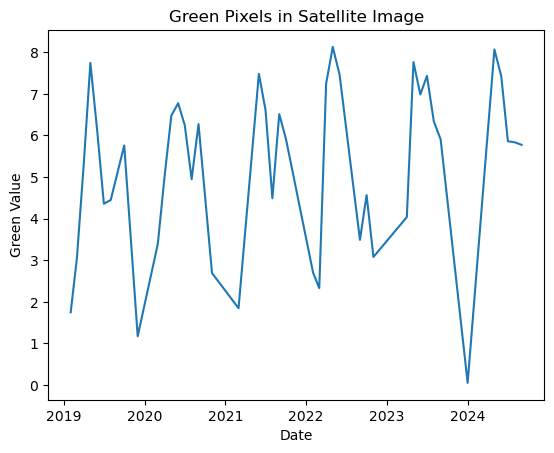

In [6]:
#plot the green data
import matplotlib.pyplot as plt
dates_filtered = np.asarray(dates)[green_values >= 0]
green_values_filtered = green_values[green_values >= 0]
plt.plot(dates_filtered,green_values_filtered)
#plt.xticks(np.arange(0, len(dates),12), rotation=45)
plt.title('Green Pixels in Satellite Image')
plt.xlabel('Date')
plt.ylabel('Green Value')
plt.savefig('green_data/green_data.png', dpi=300)
plt.show()

In [7]:
#create one long tmp_data

import datetime
from dateutil.relativedelta import relativedelta
tmp_data = []
tmp_data_labels = []
for i,tmp in enumerate(temps_monthly):
    if tmp is None:
        continue
    tmp_data.append(tmp)
    tmp_data_labels.append([(dates[i] + relativedelta(days = a)).strftime("%Y-%m-%d") for a in range(len(tmp))])
#tmp_data = np.asarray(tmp_data)
#save as csv with date
#save tmp values with date in front
with open('temperature_data/tmp_data.csv', 'w') as f:
    f.write('Date,Temperature\n')
    for i in range(len(tmp_data)):
        for a in range(len(tmp_data[i])):
            f.write(tmp_data_labels[i][a]+','+str(tmp_data[i][a])+'\n')
        # print(tmp_data_labels[i])
        # print(tmp_data[i])
        # #print(str(dates[i].strftime("%Y-%m-%d"))+','+str(green_values[i]))
        #f.write(tmp_data_labels[i]+','+str(tmp_data[i])+'\n')
#np.savetxt('temperature_data/tmp_data.csv', tmp_data, delimiter=',')


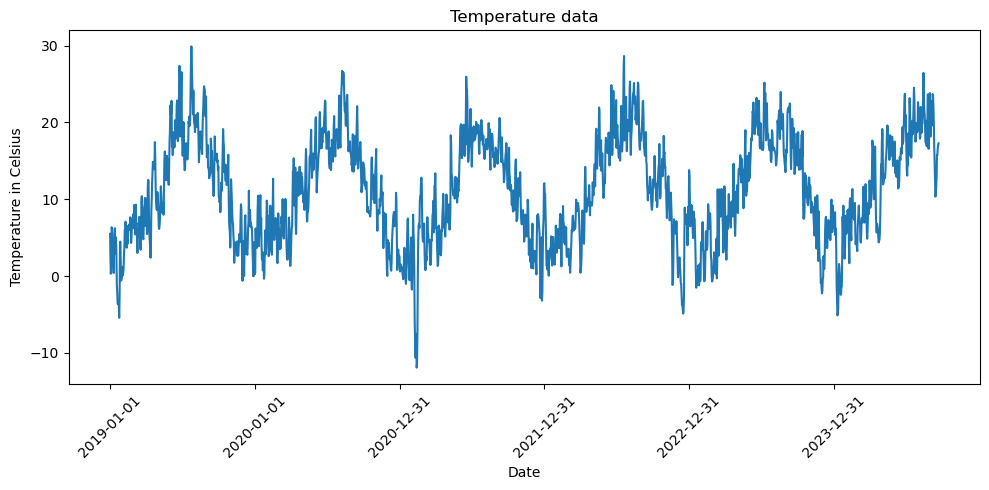

In [8]:
#plot the temperature data
#flatten tmp_data and tmp_data_labels
tmp_data_flat = [item for sublist in tmp_data for item in sublist]
tmp_data_labels_flat = [item for sublist in tmp_data_labels for item in sublist]

import matplotlib.pyplot as plt
plt.plot(tmp_data_labels_flat,tmp_data_flat)
plt.xticks(np.arange(0, len(tmp_data_labels_flat),365), rotation=45)
plt.title('Temperature data')
plt.xlabel('Date')
plt.ylabel('Temperature in Celsius')

# Adjust figure size and layout
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.tight_layout()

plt.savefig('temperature_data/tmp_data.png', dpi=300)
plt.show()

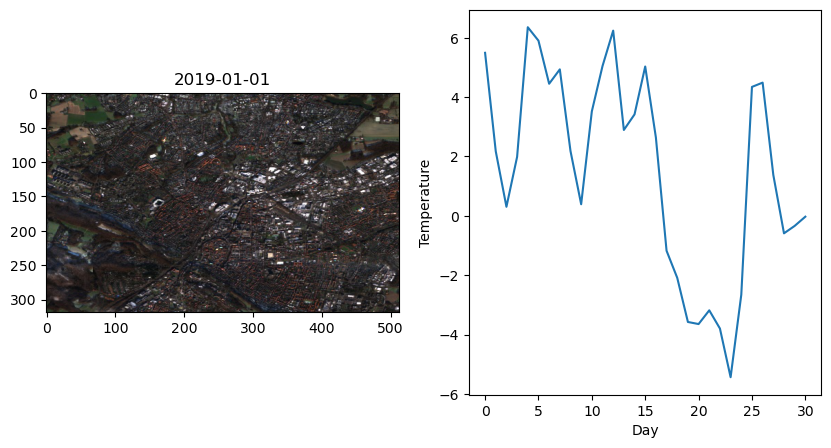

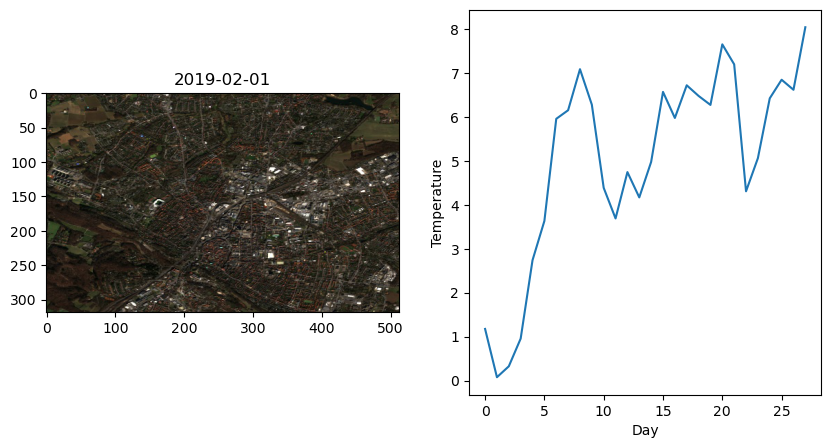

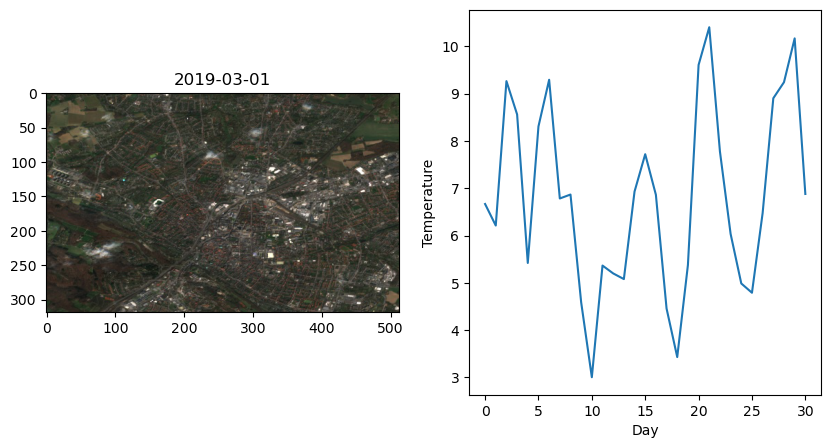

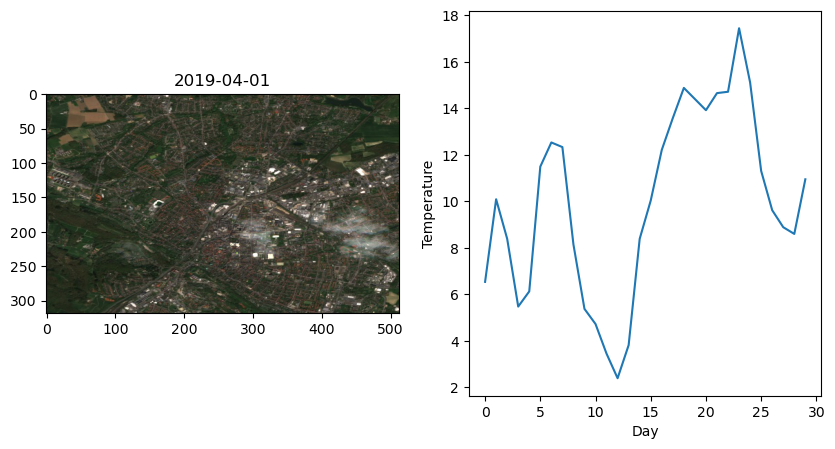

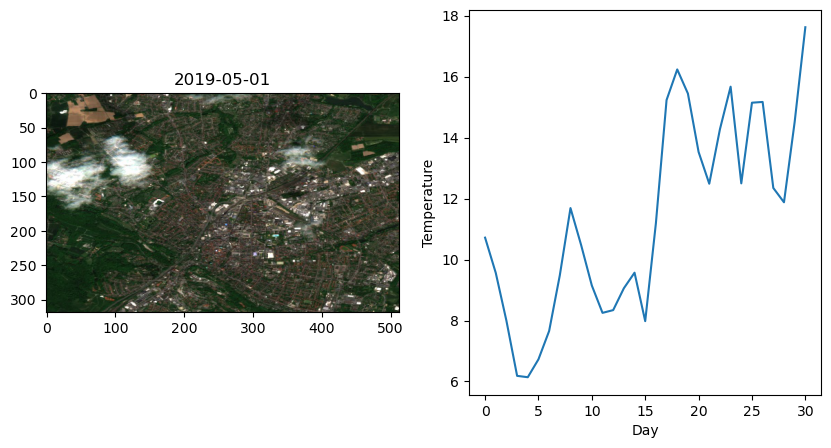

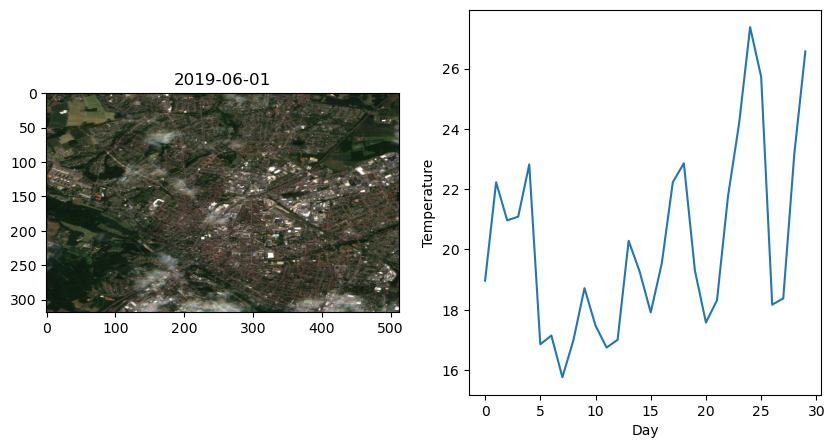

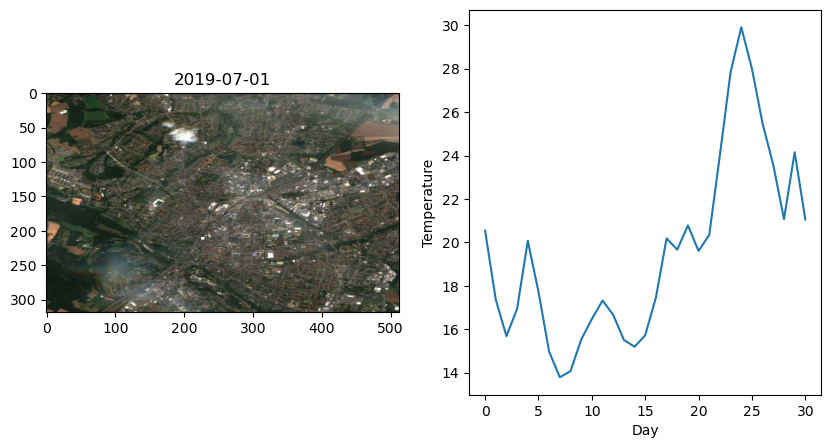

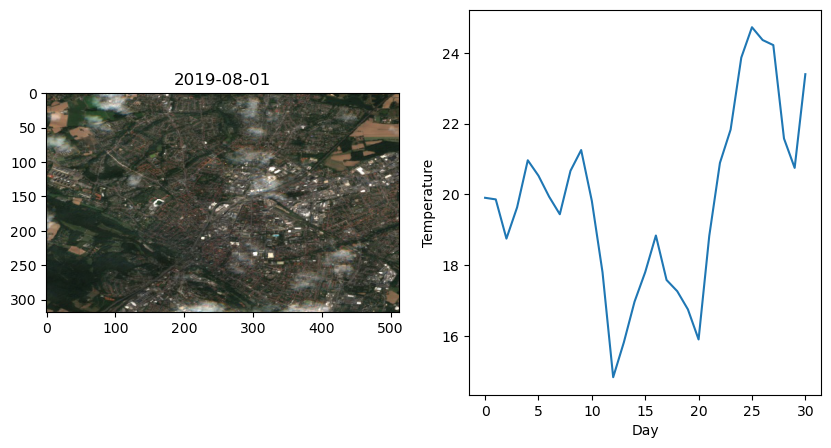

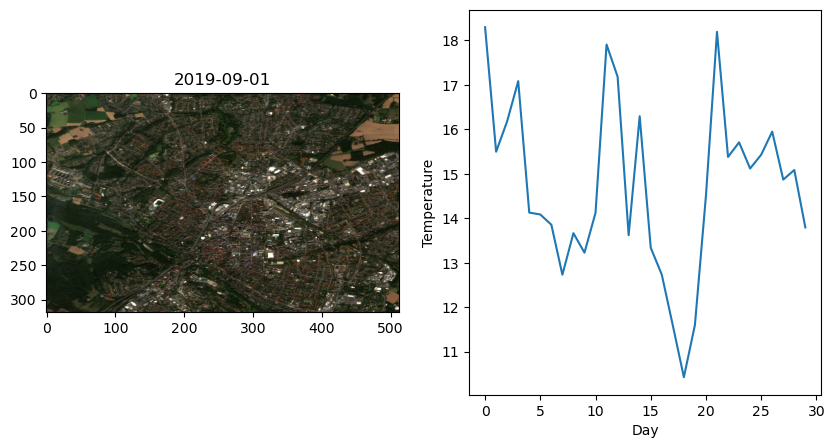

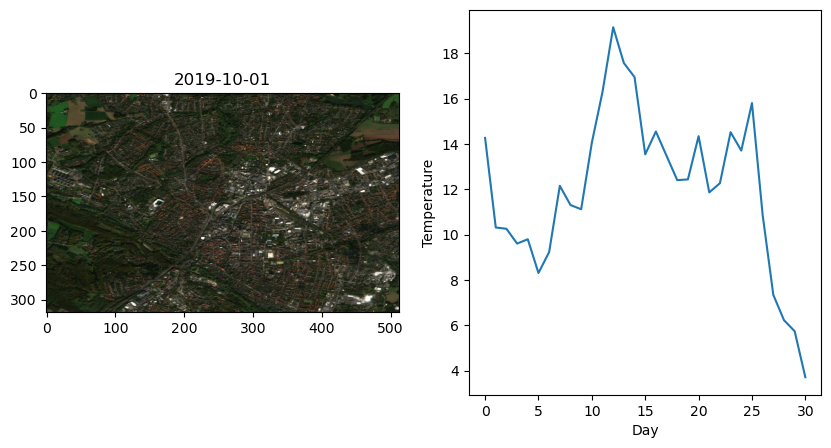

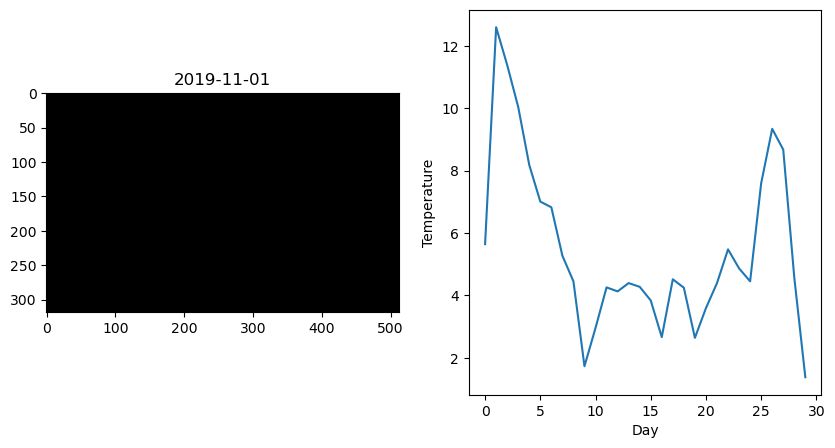

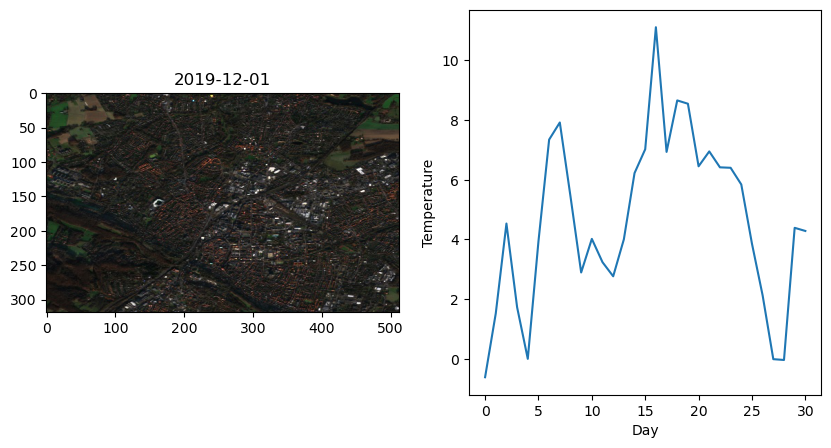

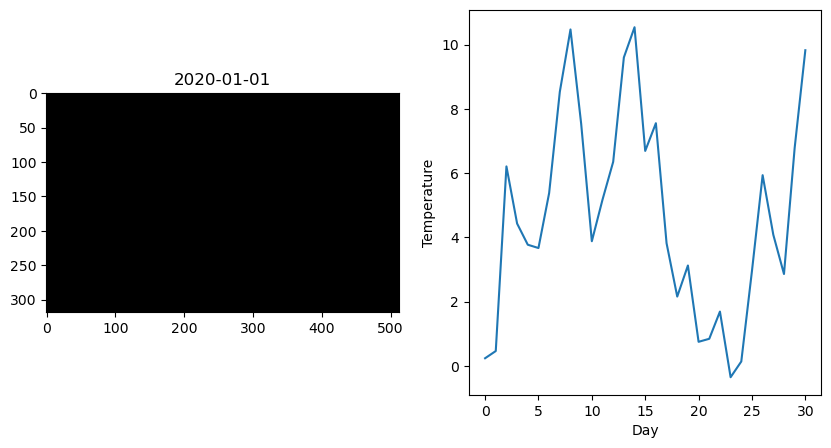

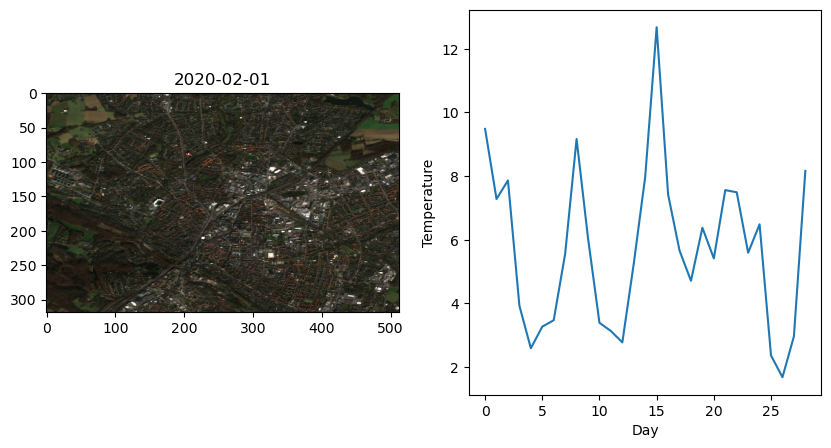

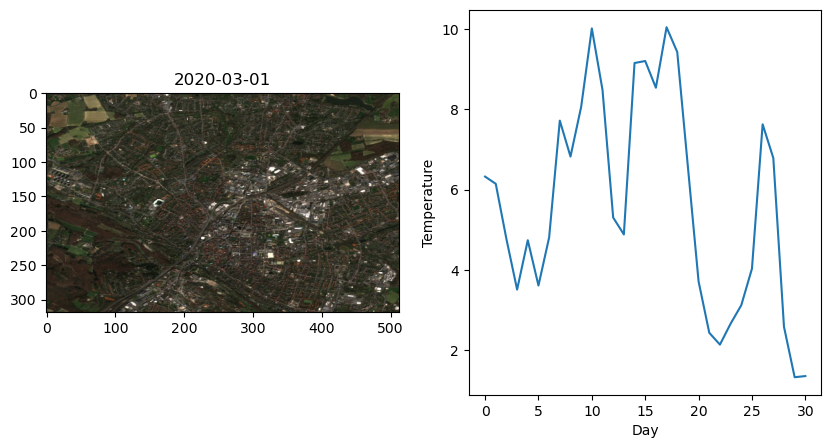

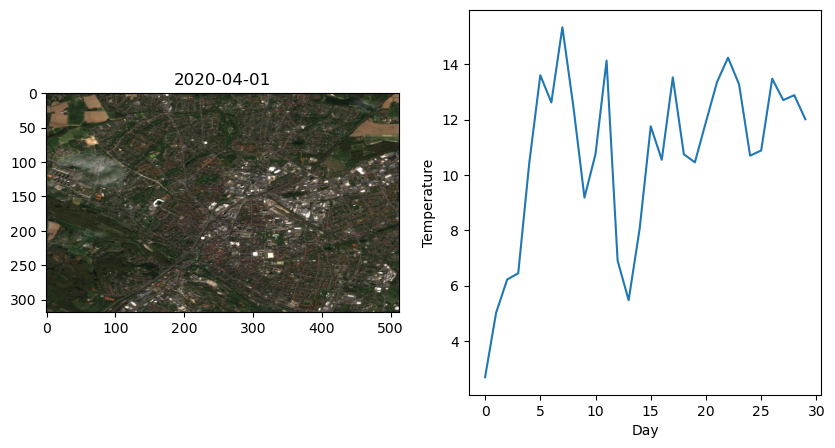

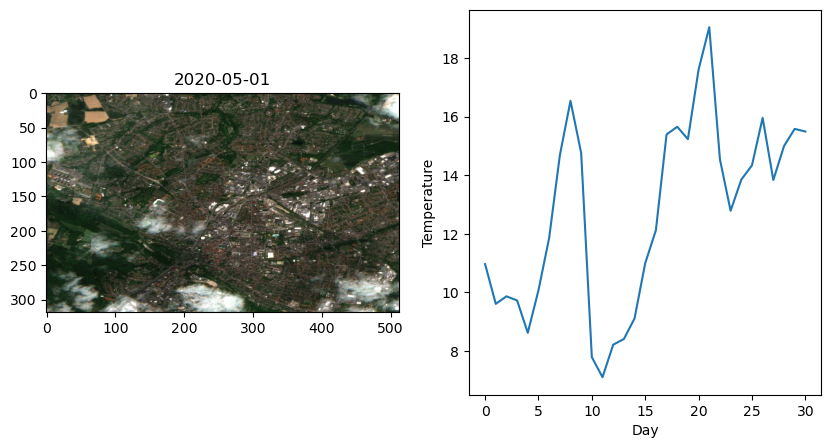

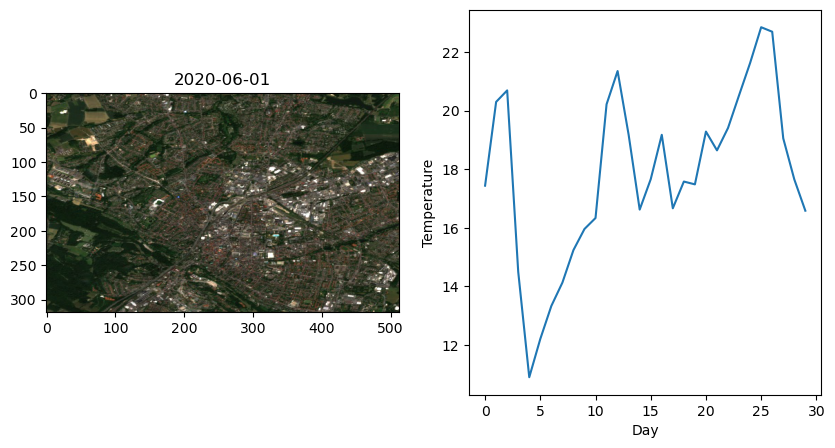

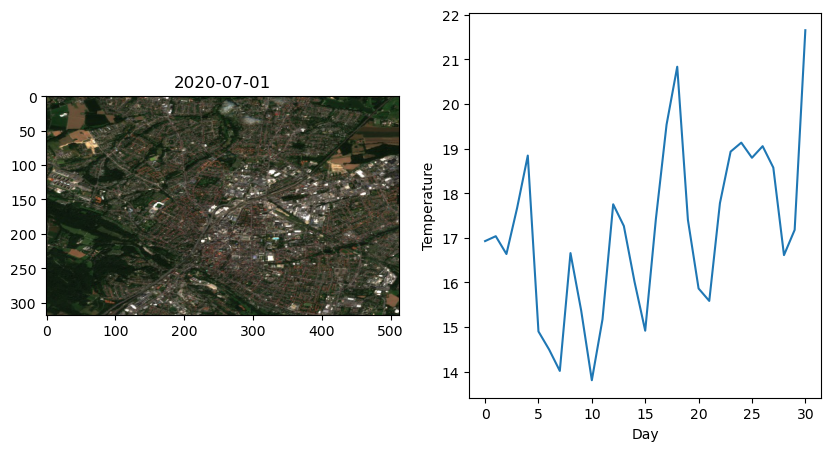

KeyboardInterrupt: 

In [3]:
import matplotlib.pyplot as plt
for i in range(len(satellite_imgs_monthly)):
    img = satellite_imgs_monthly[i]
    list_tmps = temps_monthly[i]
    date = dates[i]
    fix, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].title.set_text(date.strftime("%Y-%m-%d"))
    ax[1].plot(list_tmps)
    ax[1].set_ylabel('Temperature')
    ax[1].set_xlabel('Day')
    #ax[1].imshow(temp)
   #ax[2].imshow(cover)
    plt.show()

current year 2019
30


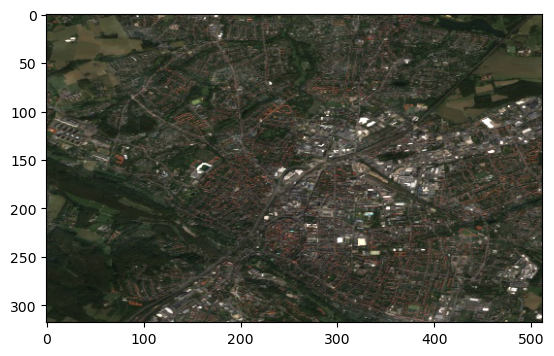

current year 2020
36


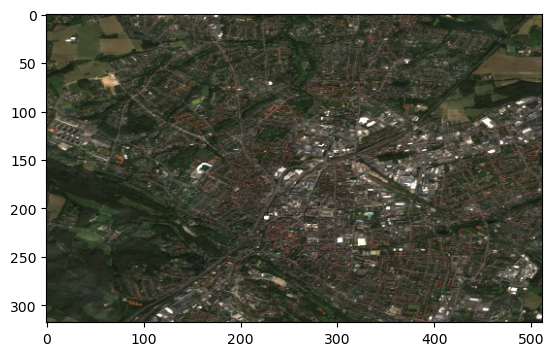

current year 2021
17


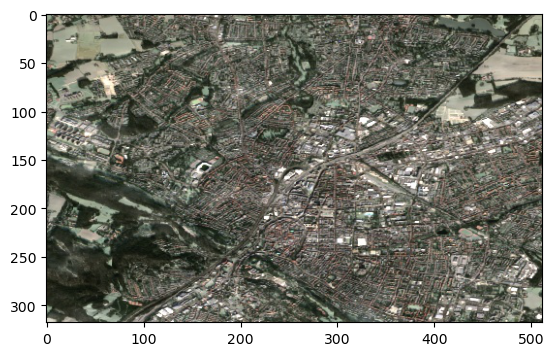

current year 2022
29


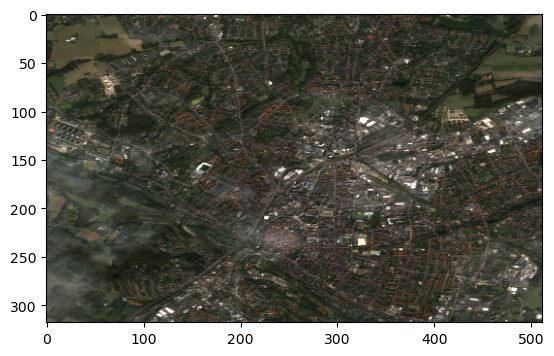

current year 2023
13


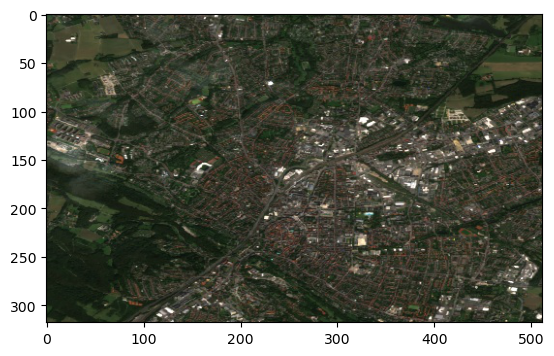

current year 2024
14


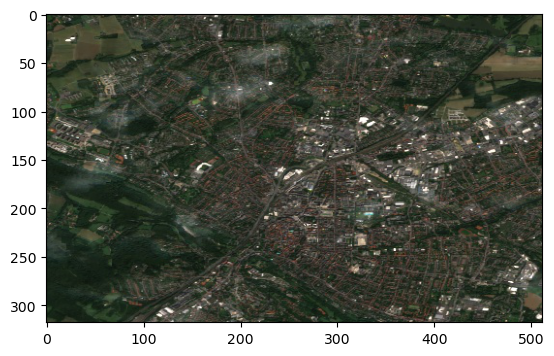

In [ ]:
def mask_s2_clouds(image):
  """Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

imgs = []
years = []


for i in range(6):
    year = 2019+i
    print("current year", year)
    years.append(year)
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(roi)
        .filterDate(str(year)+'-01-01', str(year)+'-12-30')
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', 20))
        .map(mask_s2_clouds))

    roi = u_poi.buffer(3e3)
    print(s2_sr_col.size().getInfo())
    sl2_img = s2_sr_col.mean()
    url = sl2_img.getThumbURL({'dimensions': 512, 'region': roi,'bands': ['B4', 'B3', 'B2'], "min": 0, "max": 0.3})

    array = get_img_from_url(url)
    plt.imshow(array)
    plt.show()
    imgs.append(array)
    #Image(url=url)

imgs = np.asarray(imgs)





[4.40583645 5.1245414  3.8710569  3.72810002 5.89737086 5.65084513]


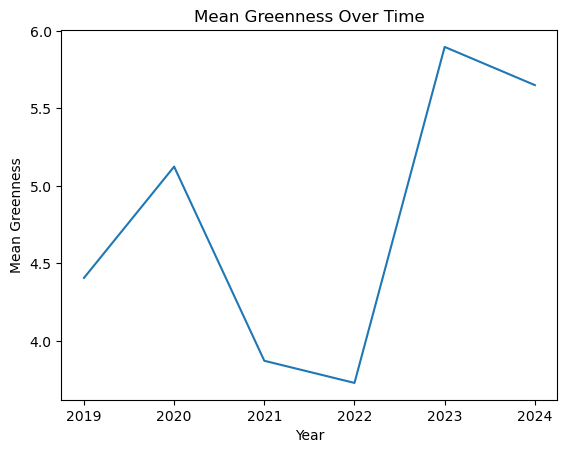

In [ ]:
brightness = np.mean(imgs, axis=(1, 2, 3))
mean_green = np.mean(imgs[:, :, :, 1], axis=(1, 2)) - brightness
print(mean_green)

plt.plot(years, mean_green)
plt.xlabel('Year')
plt.ylabel('Mean Greenness')
plt.title('Mean Greenness Over Time')
plt.show()